# 0. Data

## 0.1. Import packages

In [ ]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime, os, time

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.layers import Dropout, LSTM, Activation #, CuDNNLSTM
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import backend as K
tf.random.set_seed(123)

from keras.utils.np_utils import to_categorical

from PIL import Image

## 0.2. Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.3. Preprocessing

### 0.3.1. Open `pickle` file

In [ ]:
with open('/content/drive/MyDrive/Bayes/Term 2/Final ADL/Data/time_series_1.pickle','rb') as handle:
  time_series_1 = pickle.load(handle)
with open('/content/drive/MyDrive/Bayes/Term 2/Final ADL/Data/time_series_2.pickle','rb') as handle:
  time_series_2 = pickle.load(handle)
with open('/content/drive/MyDrive/Bayes/Term 2/Final ADL/Data/y.pickle','rb') as handle:
  y = pickle.load(handle)

The data are sensor readings and operating modes for 4,000 turbine runs. time_series_1 and
time_series_2 are NumPy arrays of shape (4000,5000). Each observation corresponds to 5,000
records of the turbine over time by one of the two sensors (time_series_1 measures the pitch
angle in each second of operation, and time_series_2 measures the generator torque). y is the
operating mode for each of the 4,000 turbine runs (0 if the turbine is healthy, 1 if the generator
torque is faulty, 2 if the pitch angle is faulty, and 3 if both are faulty). Note that the dataset is
balanced in that each operating mode is represented equally often.

### 0.3.2. Multivariates time series

In [ ]:
# change x type into float 32
time_1 = time_series_1.astype(np.float32)
time_2 = time_series_2.astype(np.float32)

In [ ]:
#np.stack((arr1, arr2), axis=2)
X = np.stack((time_1, time_2),  axis=2)

In [ ]:
# check shape 
print(X.shape)

(4000, 5000, 2)


meaning of X shape : 

- 1st dimension: 4000 runs turbine
- 2nd dimensionst: numnber of time steps per sample, which is 5000 records
- 3rd dimension: number of parallel time series, in other words, number of variables. In this case is 2 for 2 sensors

### 0.3.3. One hot encode

The target variable values are categorical and not ordinal, as well as it has less categorical values (4 values). Also, as we want to improve predictions as well as classification accuracy of a model, we will do one hot encoder with target variable prior for training

In [ ]:
y_cat = to_categorical(y)
y_cat.shape

(4000, 4)

## 0.4. Splitting data
Throughout, you should use validation and test datasets consisting of 15% of the observations each. Make sure to use the same split of observations for all tasks.

In [ ]:
# split data into train, validation and test set
other_X, test_X, other_Y, test_Y = train_test_split(X, y_cat, test_size=0.15, random_state = 123)
train_X, valid_X, train_Y, valid_Y = train_test_split(other_X, other_Y, test_size=0.15/0.85, random_state = 123)

print(test_X.shape, test_Y.shape )
print(valid_X.shape, valid_Y.shape )
print(train_X.shape, train_Y.shape )

(600, 5000, 2) (600, 4)
(600, 5000, 2) (600, 4)
(2800, 5000, 2) (2800, 4)


# 1. Using RNN



## 1.1. Function to plot train and validation loss

For multi-class classification, we will use `‘categorical_crossentropy‘` when calling the `compile()` function. This type of loss is suitable for multi classification, with the target variable has been done with one hot encoded prior to training.

For optimizer, we would choose `Adam`, since the weights are adjusted based on the moving average of gradients calculated in current and previous epochs. The moments adjustment as per the Adam algorithm is calculated as moving average of previous and current gradients and then those moments are used to update the weights.

In [ ]:
def train_plot(model, ep ):
  # train model
  np.random.seed(312)
  tf.random.set_seed(312)

  model.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate = 0.001, decay=1e-6),
                metrics=['accuracy']
                )
  log = model.fit(train_X, train_Y, 
                  epochs = ep ,
                  validation_data=(valid_X, valid_Y),
                  )
  # plot loss
  plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
  plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
  plt.legend()
  ax = plt.gca()
  plt.show()
    
  return model

## 1.2. Fiting model with different method 

### 1.2.1. Linear regression 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 4)                 40004     
                                                                 
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 1s 7ms/step - loss: 7.6399 - accuracy: 0.2618 - val_loss: 12.3035 - val_accuracy: 0.2850
Epoch 2/20
88/88 [==============================] - 0s 5ms/step - loss: 11.9562 - accuracy: 0.2493 - val_loss: 12.3035 - val_accuracy: 0.2850
Epoch 3/20
88/88 [==============================] - 1s 6ms/step - loss: 11.9562 - accuracy: 0.2493 - val_loss: 12.3035 - val_accuracy: 0.2850
Epoch 4/20
88/88 [===

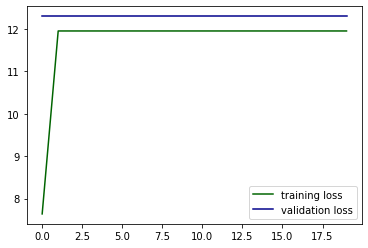

In [ ]:
linear_model = Sequential([
    Flatten(input_shape= X.shape[1:]),
    Dense(4)
])
linear_model.summary()
train_plot(linear_model, 20 )

In [ ]:
# evaluate the model
test_loss_linear, test_acc_linear  = linear_model.evaluate(test_X, test_Y)
print("Test Accuracy for Linear Regression is",np.round((test_acc_linear)*100,2))

19/19 [==============================] - 0s 3ms/step - loss: 12.4915 - accuracy: 0.2300
Test Accuracy for Linear Regression is 23.0


This method is time saving. However, the loss is quite high, and the accuracy acquired is only 23%, which is pretty low.

### 1.2.2. Simple RNN

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 4         
                                                                 
 dense_2 (Dense)             (None, 4)                 8         
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 51s 567ms/step - loss: 1.3760 - accuracy: 0.3100 - val_loss: 1.3693 - val_accuracy: 0.3617
Epoch 2/20
88/88 [==============================] - 50s 569ms/step - loss: 1.3723 - accuracy: 0.3225 - val_loss: 1.3669 - val_accuracy: 0.3667
Epoch 3/20
88/88 [==============================] - 50s 568ms/step - loss: 1.3693 - accuracy: 0.3304 - val_loss: 1.3624 - val_accuracy: 0.3717
Epoch 4/20
88/88 [=======

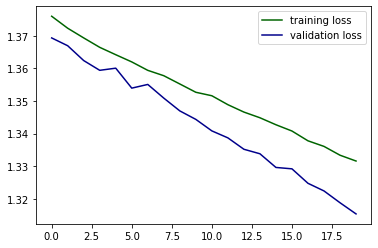

In [ ]:
## Simple RNN
model_simple_RNN = Sequential()
model_simple_RNN.add(SimpleRNN(1, input_shape=X.shape[1:]))
model_simple_RNN.add(Dense(4, activation='softmax'))

model_simple_RNN.summary()
train_plot(model_simple_RNN, 20)

In [ ]:
test_loss_simpleRNN, test_acc_simpleRNN  = model_simple_RNN.evaluate(test_X, test_Y)
print("Test Accuracy of Simple RNN model is",np.round((test_acc_simpleRNN)*100,2))

19/19 [==============================] - 3s 132ms/step - loss: 1.3306 - accuracy: 0.3683
Test Accuracy of Simple RNN model is 36.83


This method is slower than the Linear regression. However, eventhough both of the loss and accuracy have been improves, the results for accuracy is still lower than 40%.

### 1.2.3. Deeper RNN

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 5000, 20)          460       
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_14 (Dense)            (None, 4)                 84        
                                                                 
Total params: 1,364
Trainable params: 1,364
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 379s 4s/step - loss: 1.2919 - accuracy: 0.3996 - val_loss: 1.2122 - val_accuracy: 0.4867
Epoch 2/20
88/88 [==============================] - 381s 4s/step - loss: 1.1666 - accuracy: 0.4793 - val_loss: 1.1401 - val_accuracy: 0.4750
Epoch 3/20
88/88 [===============

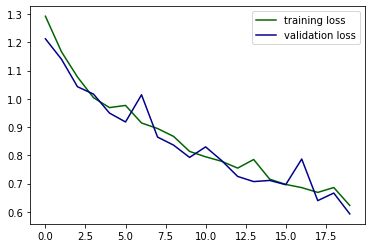

In [ ]:
## Deeper RNN
model_deeper = Sequential()
model_deeper.add(SimpleRNN(20, return_sequences=True, input_shape=X.shape[1:]))
model_deeper.add(SimpleRNN(20))
model_deeper.add(Dense(4, activation='softmax'))

model_deeper.summary()

train_plot(model_deeper, 20)

In [ ]:
test_loss_deeperRNN, test_acc_deeperRNN   = model_deeper.evaluate(test_X, test_Y)
print("Test Accuracy of Simple RNN model is",np.round((test_acc_deeperRNN)*100,2))

19/19 [==============================] - 7s 383ms/step - loss: 0.6198 - accuracy: 0.7783
Test Accuracy of Simple RNN model is 77.83


Although this model is quite time-consuming, the accuracy for test set is high, with nearly 78%. Moreover, looking at the loss plot, it seems like the more epoch we try, the less loss we have. However, in this case we will examine only 20 epochs for saving time. 

### 1.2.3. Long Short Term Memory (LSTM)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5000, 20)          1840      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dense_3 (Dense)             (None, 4)                 84        
                                                                 
Total params: 5,204
Trainable params: 5,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 562s 6s/step - loss: 1.3870 - accuracy: 0.2479 - val_loss: 1.3880 - val_accuracy: 0.2367
Epoch 2/20
88/88 [==============================] - 582s 7s/step - loss: 1.3866 - accuracy: 0.2461 - val_loss: 1.3869 - val_accuracy: 0.2367
Epoch 3/20
88/88 [================

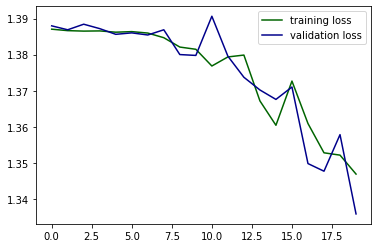

In [ ]:
## LSTM 
model_LSTM = Sequential()
model_LSTM.add(LSTM(20, return_sequences=True, input_shape= X.shape[1:]))
model_LSTM.add(LSTM(20))
model_LSTM.add(Dense(4, activation='softmax'))

model_LSTM.summary()

train_plot(model_LSTM, 20)

In [ ]:
test_loss_LSTM, test_acc_LSTM   = model_LSTM.evaluate(test_X, test_Y)
print("Test Accuracy of LSTM model is",np.round((test_acc_LSTM)*100,2))

19/19 [==============================] - 13s 640ms/step - loss: 1.3476 - accuracy: 0.3050
Test Accuracy of LSTM model is 30.5


This method is the most time-consuming untill now. Eventhough it seems like the loss has been decreasing over epochs, however, it's loss is still higher than others method. Additionally, the accuracy of test set is even not as high as the simple RNN method.

### 1.2.4. GRUs

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 5000, 20)          1440      
                                                                 
 gru_3 (GRU)                 (None, 20)                2520      
                                                                 
 dense_3 (Dense)             (None, 4)                 84        
                                                                 
Total params: 4,044
Trainable params: 4,044
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 522s 6s/step - loss: 1.3873 - accuracy: 0.2461 - val_loss: 1.3870 - val_accuracy: 0.2550
Epoch 2/20
88/88 [==============================] - 509s 6s/step - loss: 1.3867 - accuracy: 0.2625 - val_loss: 1.3874 - val_accuracy: 0.2367
Epoch 3/20
88/88 [================

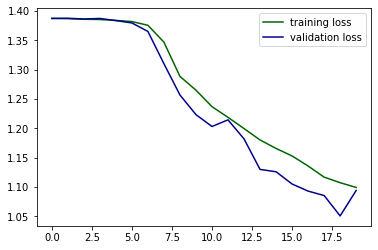

In [ ]:
## GRU
model_gru = Sequential()
model_gru.add(GRU(20, return_sequences=True, input_shape= X.shape[1:]))
model_gru.add(GRU(20))
model_gru.add(Dense(4, activation ="softmax") )

model_gru.summary()

train_plot(model_gru, 20)

In [ ]:
test_loss_GRUs, test_acc_GRUs   = model_gru.evaluate(test_X, test_Y)
print("Test Accuracy of GRUs model is",np.round((test_acc_GRUs)*100,2))

19/19 [==============================] - 10s 506ms/step - loss: 1.1358 - accuracy: 0.4817
Test Accuracy of GRUs model is 48.17


This methos is time consuming also. The accuracy for test set is around 48%, which is still better than LSTM method when comparing the same time for each epoch runs.

### 1.2.5. 1-dimensional convolutional layers

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2499, 20)          180       
                                                                 
 gru_3 (GRU)                 (None, 20)                2520      
                                                                 
 dense_6 (Dense)             (None, 4)                 84        
                                                                 
Total params: 2,784
Trainable params: 2,784
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 152s 2s/step - loss: 1.3869 - accuracy: 0.2479 - val_loss: 1.3849 - val_accuracy: 0.3600
Epoch 2/20
88/88 [==============================] - 144s 2s/step - loss: 1.3849 - accuracy: 0.2821 - val_loss: 1.3831 - val_accuracy: 0.2367
Epoch 3/20
88/88 [================

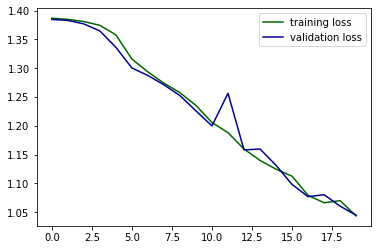

In [ ]:
model_conv1D = Sequential()
model_conv1D.add(Conv1D(filters=20, kernel_size=4, strides=2, 
                        padding="valid",input_shape=X.shape[1:]) )
model_conv1D.add(GRU(20))
model_conv1D.add(Dense(4, activation ="softmax") )

model_conv1D.summary()

train_plot(model_conv1D, 20)

In [ ]:
test_loss_conv1D, test_acc_conv1D   = model_conv1D.evaluate(test_X, test_Y)
print("Test Accuracy of Conv1D model is",np.round((test_acc_conv1D)*100,2))

19/19 [==============================] - 4s 212ms/step - loss: 1.0926 - accuracy: 0.5100
Test Accuracy of Conv1D model is 51.0


## 1.3. Choosing model
As we can see, most of the method are quite time consuming. After considering several model, the model that gave us the highest accuracy for the test set is Deeper RNN, which is about 78% for accuracy .

The reason is that deeper network is a more complex method and non-linear function can be learned. Given sufficient training data, this enables the networks to more easily discriminate between different classes.

# 2. Convert the data for use with a CNN

Base on the above image, each time series will be 1 columns. Therefore, we will first reshape our 2 time series set, to make one wind turbine in each time series into a single (100,50), then combine them together later to make them into shape (100,100)

In [ ]:
# reshape 2 time series
series_1_reshape = time_1.reshape(time_1.shape[0], 100, 50)
series_2_reshape = time_2.reshape(time_2.shape[0], 100, 50)
x_reshape = np.concatenate((series_1_reshape, series_2_reshape), axis =2 )
x_reshape.shape

(4000, 100, 100)

In [ ]:
# split data into train, validation and test set
other_X_reshape, test_X_reshape, other_Y_reshape, test_Y_reshape = train_test_split(x_reshape, y, test_size=0.15, random_state = 123)
train_X_reshape, valid_X_reshape, train_Y_reshape, valid_Y_reshape = train_test_split(other_X_reshape, other_Y_reshape, 
                                                                                      test_size=0.15/0.85, random_state = 123)
print(test_X_reshape.shape, test_Y_reshape.shape)
print(valid_X_reshape.shape, valid_Y_reshape.shape)
print(train_X_reshape.shape, train_Y_reshape.shape)

(600, 100, 100) (600,)
(600, 100, 100) (600,)
(2800, 100, 100) (2800,)


Let's plot image of `train_x_reshape`

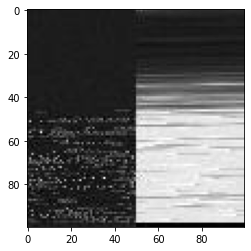

In [ ]:
plt.imshow(train_X_reshape[0],cmap = 'gray')

In [ ]:
# encode y 
y_test_reshape = to_categorical(test_Y_reshape)
y_valid_reshape = to_categorical(valid_Y_reshape)
y_train_reshape = to_categorical(train_Y_reshape)
# check shape 
print(y_train_reshape.shape)
print(y_valid_reshape.shape)
print(y_test_reshape.shape)

(2800, 4)
(600, 4)
(600, 4)


We would normalize the values to range from 0 to 1. In this way, the numbers will be small and the computation becomes easier and faster. So dividing all the values by 255 will convert it to range from 0 to 1

In [ ]:
# reshape data for CNN
# change into shape (100,100,1), and scaled data
x_train_reshape = train_X_reshape[..., np.newaxis] / 255.
x_valid_reshape = valid_X_reshape[..., np.newaxis] / 255.
x_test_reshape = test_X_reshape[..., np.newaxis] / 255.
# check shape 
print(x_train_reshape.shape)
print(x_valid_reshape.shape)
print(x_test_reshape.shape)

(2800, 100, 100, 1)
(600, 100, 100, 1)
(600, 100, 100, 1)


# 3. CNN with two convolutional layers

In [ ]:
# build model
fig12 = Sequential()

fig12.add(Conv2D(32, (3,3), input_shape = x_train_reshape.shape[1:]))
fig12.add(Conv2D(32, (3,3)))
fig12.add(Dropout(0.2))

fig12.add(Conv2D(16, (3,3)) )
fig12.add(Activation('relu'))
fig12.add(MaxPooling2D(pool_size=(3, 3)))

fig12.add(Flatten())  # this converts our 4D feature maps to 2D feature vectors
fig12.add(Dense(4,activation='softmax'))

fig12.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 dropout_2 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 94, 94, 16)        4624      
                                                                 
 activation_24 (Activation)  (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                     

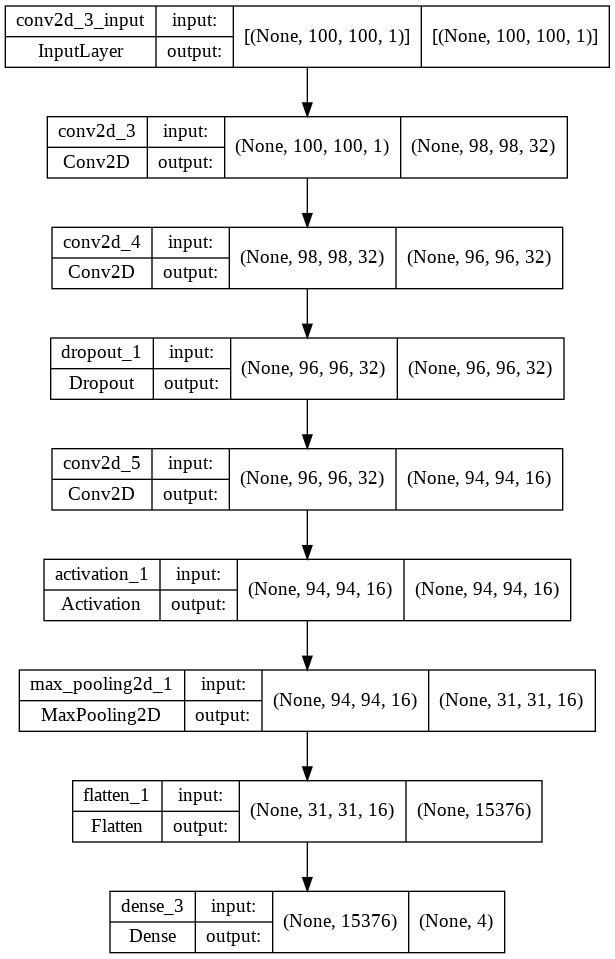

In [ ]:
keras.utils.plot_model(fig12, show_shapes=True)

In [ ]:
fig12.compile(loss="categorical_crossentropy", # for one hot encode output 
              # The RMSprop optimizer restricts the oscillations in the vertical direction. 
              # Therefore, we can increase our learning rate and our algorithm could take larger steps 
              # in the horizontal direction converging faster. 
              optimizer='rmsprop',
              metrics=['accuracy'])
log_fig12 = fig12.fit(x_train_reshape, y_train_reshape, epochs=40,
                    validation_data=(x_valid_reshape, y_valid_reshape),
                    verbose=1, 
                    )

Epoch 1/40
88/88 [==============================] - 99s 1s/step - loss: 11.4510 - accuracy: 0.6093 - val_loss: 0.3196 - val_accuracy: 0.8867
Epoch 2/40
88/88 [==============================] - 98s 1s/step - loss: 0.3749 - accuracy: 0.8657 - val_loss: 0.4786 - val_accuracy: 0.8517
Epoch 3/40
88/88 [==============================] - 98s 1s/step - loss: 0.3270 - accuracy: 0.8757 - val_loss: 0.7199 - val_accuracy: 0.7650
Epoch 4/40
88/88 [==============================] - 98s 1s/step - loss: 0.2891 - accuracy: 0.8832 - val_loss: 0.2514 - val_accuracy: 0.8867
Epoch 5/40
88/88 [==============================] - 98s 1s/step - loss: 0.2822 - accuracy: 0.8807 - val_loss: 0.2721 - val_accuracy: 0.8850
Epoch 6/40
88/88 [==============================] - 98s 1s/step - loss: 0.2708 - accuracy: 0.8900 - val_loss: 0.3628 - val_accuracy: 0.7900
Epoch 7/40
88/88 [==============================] - 98s 1s/step - loss: 0.2756 - accuracy: 0.8804 - val_loss: 0.3063 - val_accuracy: 0.8350
Epoch 8/40
88/88 [=

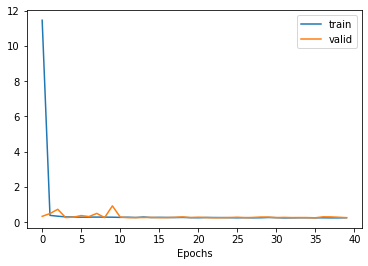

In [ ]:
# Visualising Training and Validation Loss
plt.plot(log_fig12.history['loss'], label='train')
plt.plot(log_fig12.history['val_loss'], label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.show()

Text(0.5, 0, 'Epochs')

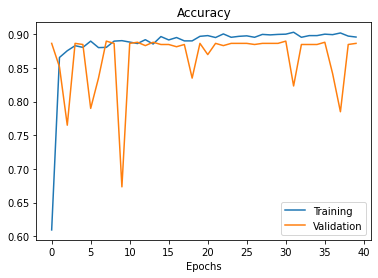

In [ ]:
## Visualising Training and Validation Accuracy
plt.plot(log_fig12.history['accuracy'])
plt.plot(log_fig12.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

To plot above visulaized how loss and accuracy of training and validation set looks like. It seems like loss of this model for validation set quite low and stable, while the accuracy is fluctuate. However, the accuracy final validation set is high, which is around 88%. 

In [ ]:
val_loss, val_acc = fig12.evaluate(x_test_reshape, y_test_reshape)  # evaluate the out of sample data with model
print("Model's loss (error) is",round(val_loss*100,2))  # model's loss (error)
print("Model's accuracy is",round(val_acc*100,2))  # model's accuracy

19/19 [==============================] - 4s 212ms/step - loss: 0.2628 - accuracy: 0.8867
Model's loss (error) is 26.28
Model's accuracy is 88.67


For evaluating the test set, we have seen that CNN model has the accuracy of 88%, which is the best accuracy so far. Also, the gap between accuracy of validation set and test set were not too high, which is exceptable, and it also indicates that our model have not been overfitted. The reason for better accuracy compared to RNN method is that CNNs work well with data that has a spatial relationship (in this case is pitch angle and the generator torque)

# 4. Adjusting the CNN

## Pre-trained CNN

The paper has already tune with different nodes per layer (20, 32, 128) and different convulational layers (1,2,3,4). In this pre-trained step, we would also try to change different number of nodes per layers, convulational layers and dense layers but with some otherd random combination to compared them.

For better CNN model, we will try to play with several random number of node-per-layer like (16,32,64,128) and convulational layers like (1,2,3). For the dense layers, we will keep it as 4 over all tuning trial as we want to keep it simple. Then, we will use Tensorboard to better visualize our model's training stats over time.

In [ ]:
%load_ext tensorboard

In [ ]:
rm -rf ./logs/

In [ ]:
dense_layer = 4
layer_sizes = [16, 32, 64, 128]
conv_layers = [1, 2, 3]

for layer_size in layer_sizes:
    for conv_layer in conv_layers:
        NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, 4, int(time.time()))
        print(NAME)

        model = Sequential()

        model.add(Conv2D(layer_size, (3, 3), input_shape=x_train_reshape.shape[1:]))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        for l in range(conv_layer-1):
            model.add(Conv2D(layer_size, (3, 3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        for _ in range(dense_layer):
            model.add(Dense(layer_size))
            model.add(Activation('relu'))

        model.add(Dense(4))
        model.add(Activation('softmax'))

        tensorboard_callback = TensorBoard(log_dir="logs/{}".format(NAME))

        model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'],
                      )

        model.fit(x_train_reshape, y_train_reshape,
                  epochs=20,
                  validation_data=(x_valid_reshape, y_valid_reshape),
                  callbacks=[tensorboard_callback]
                  )

1-conv-16-nodes-4-dense-1649656502
Epoch 1/20
88/88 [==============================] - 12s 121ms/step - loss: 1.4055 - accuracy: 0.2764 - val_loss: 1.3674 - val_accuracy: 0.2517
Epoch 2/20
88/88 [==============================] - 9s 101ms/step - loss: 1.3869 - accuracy: 0.2393 - val_loss: 1.3864 - val_accuracy: 0.2467
Epoch 3/20
88/88 [==============================] - 9s 101ms/step - loss: 1.3865 - accuracy: 0.2450 - val_loss: 1.3869 - val_accuracy: 0.2367
Epoch 4/20
88/88 [==============================] - 9s 101ms/step - loss: 1.3864 - accuracy: 0.2546 - val_loss: 1.3871 - val_accuracy: 0.2367
Epoch 5/20
88/88 [==============================] - 9s 102ms/step - loss: 1.3863 - accuracy: 0.2582 - val_loss: 1.3872 - val_accuracy: 0.2367
Epoch 6/20
88/88 [==============================] - 9s 102ms/step - loss: 1.3863 - accuracy: 0.2582 - val_loss: 1.3872 - val_accuracy: 0.2367
Epoch 7/20
88/88 [==============================] - 9s 102ms/step - loss: 1.3863 - accuracy: 0.2582 - val_loss: 

In [ ]:
%tensorboard --logdir logs

Eventhough the running took some significant time, the 2 interacting graph give us a better visualization of accuracy and loss at each time we run the different models. However, we will tempt to prioritize model which give us low loss for final validation set as there is some randomness when it comes to the models, and then look at its accuracy for further validation. 

We would zoom in validation loss, and these are top 5 lowest:

*   2-conv-128-nodes
*   2-conv-64-nodes
*   3-conv-32-nodes
*   3-conv-64-nodes
*   3-conv-128-nodes

And these are top 5 best accuracy:

*   1-conv-128-nodes
*   2-conv-128-nodes
*   3-conv-32-nodes
*   2-conv-64-nodes
*   3-conv-128-nodes

It seems like 128 nodes with 2 convulational layers give us a quite good models. Therefore we would choose this combination for further training model.



## Training model 

In [ ]:
dense_layer = 4
layer_sizes = [128]
conv_layers = [2]

for layer_size in layer_sizes:
    for conv_layer in conv_layers:
        NAME = "{}-conv-{}-nodes-{}-dense".format(conv_layer, layer_size, 4)
        print(NAME)

        model_tune = Sequential()

        model_tune.add(Conv2D(layer_size, (3, 3), input_shape=x_train_reshape.shape[1:]))
        model_tune.add(Activation('relu'))
        model_tune.add(MaxPooling2D(pool_size=(2, 2)))

        for l in range(conv_layer-1):
            model_tune.add(Conv2D(layer_size, (3, 3)))
            model_tune.add(Activation('relu'))
            model_tune.add(MaxPooling2D(pool_size=(2, 2)))

        model_tune.add(Flatten())
        for _ in range(dense_layer):
            model_tune.add(Dense(layer_size))
            model_tune.add(Activation('relu'))

        model_tune.add(Dense(4))
        model_tune.add(Activation('softmax'))

        model_tune.summary()

        model_tune.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'],
                      )

        model_tune.fit(x_train_reshape, y_train_reshape,
                  epochs=10,
                  validation_data=(x_valid_reshape, y_valid_reshape),
                  )

2-conv-128-nodes-4-dense
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 128)       1280      
                                                                 
 activation_13 (Activation)  (None, 98, 98, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 128)       147584    
                                                                 
 activation_14 (Activation)  (None, 47, 47, 128)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                         

In [ ]:
val_loss_tune, val_acc_tune = model_tune.evaluate(x_test_reshape, y_test_reshape)  # evaluate the out of sample data with model
print("Model's loss (error) is",round(val_loss_tune*100,2))  # model's loss (error)
print("Model's accuracy is",round(val_acc_tune*100,2))  # model's accuracy

19/19 [==============================] - 7s 385ms/step - loss: 0.2677 - accuracy: 0.8900
Model's loss (error) is 26.77
Model's accuracy is 89.0


This model is the best so far, hence, we will use this model.

In [ ]:
# save model
model_tune.save('best_model_CNN.h5') 

# 5. Augmentation data

Also, we would try to better train our model. Hence, we would try to fit the best model so far into augmentation data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
dense_layer = 4
layer_sizes = [128]
conv_layers = [2]

for layer_size in layer_sizes:
    for conv_layer in conv_layers:
        NAME = "{}-conv-{}-nodes-{}-dense".format(conv_layer, layer_size, 4)
        print(NAME)

        model_aug = Sequential()

        model_aug.add(Conv2D(layer_size, (3, 3), input_shape=x_train_reshape.shape[1:]))
        model_aug.add(Activation('relu'))
        model_aug.add(MaxPooling2D(pool_size=(2, 2)))

        for l in range(conv_layer-1):
            model_aug.add(Conv2D(layer_size, (3, 3)))
            model_aug.add(Activation('relu'))
            model_aug.add(MaxPooling2D(pool_size=(2, 2)))

        model_aug.add(Flatten())
        for _ in range(dense_layer):
            model_aug.add(Dense(layer_size))
            model_aug.add(Activation('relu'))

        model_aug.add(Dense(4))
        model_aug.add(Activation('softmax'))

        model_aug.summary()

        model_aug.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'],
                      )

2-conv-128-nodes-4-dense
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 128)       1280      
                                                                 
 activation_20 (Activation)  (None, 98, 98, 128)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 128)       147584    
                                                                 
 activation_21 (Activation)  (None, 47, 47, 128)       0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                         

In [ ]:
# function to plot val loss and fit test data
def plot_train_augmentation(x):
  log_aug = model_aug.fit(x, y_train_reshape, epochs=5,
                    validation_data=(x_valid_reshape, y_valid_reshape),
                    verbose=1, 
                    )
  
  # plot loss
  plt.plot(log_aug.history['loss'],label = "training loss",color='darkgreen')
  plt.plot(log_aug.history['val_loss'], label = "validation loss",color='darkblue')
  plt.legend()
  ax = plt.gca()
  plt.show()

  # evaluation 
  test_loss, test_acc  = model_aug.evaluate(x_test_reshape, y_test_reshape)
  print("Test Accuracy of model is",np.round((test_acc)*100,2))

We will try with random shifts and random rotation augmentation to compared each model.

We will train model to expect and currently handle off-center objects by artificially creating shifted versions of your training data. By using, random shifts, it supports separate horizontal and vertical random shifting of training data by the width_shift_range and height_shift_range arguments.

Epoch 1/5
88/88 [==============================] - 97s 1s/step - loss: 0.2711 - accuracy: 0.8914 - val_loss: 0.2777 - val_accuracy: 0.8767
Epoch 2/5
88/88 [==============================] - 95s 1s/step - loss: 0.2440 - accuracy: 0.8943 - val_loss: 0.2569 - val_accuracy: 0.8883
Epoch 3/5
88/88 [==============================] - 96s 1s/step - loss: 0.2541 - accuracy: 0.8943 - val_loss: 0.2425 - val_accuracy: 0.8883
Epoch 4/5
88/88 [==============================] - 95s 1s/step - loss: 0.2486 - accuracy: 0.8968 - val_loss: 0.2509 - val_accuracy: 0.8867
Epoch 5/5
88/88 [==============================] - 95s 1s/step - loss: 0.2570 - accuracy: 0.9000 - val_loss: 0.2431 - val_accuracy: 0.8867


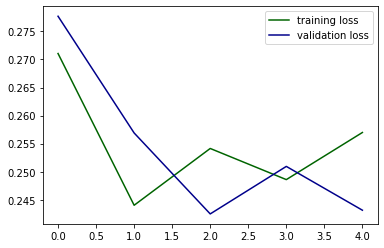

19/19 [==============================] - 4s 201ms/step - loss: 0.2621 - accuracy: 0.8900
Test Accuracy of Conv1D model is 89.0


In [ ]:
###### Random Shifts
x_random_shift = x_train_reshape
# define data preparation
shift = 0.2
datagen_random_shift = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen_random_shift.fit(x_random_shift)
# plot
plot_train_augmentation(x_random_shift)

A rotation augmentation randomly rotates the image clockwise by a given number of degrees from 0 to 360. The rotation will likely rotate pixels out of the image frame and leave areas of the frame with no pixel data that must be filled in. In this case we will try random rotations via the rotation_range argument, with rotations to the image between 0 and 90 degrees.

Epoch 1/5
88/88 [==============================] - 95s 1s/step - loss: 0.2601 - accuracy: 0.8982 - val_loss: 0.2496 - val_accuracy: 0.8883
Epoch 2/5
88/88 [==============================] - 93s 1s/step - loss: 0.2515 - accuracy: 0.8968 - val_loss: 0.2431 - val_accuracy: 0.8883
Epoch 3/5
88/88 [==============================] - 93s 1s/step - loss: 0.2609 - accuracy: 0.8961 - val_loss: 0.2441 - val_accuracy: 0.8867
Epoch 4/5
88/88 [==============================] - 94s 1s/step - loss: 0.2475 - accuracy: 0.8996 - val_loss: 0.2587 - val_accuracy: 0.8833
Epoch 5/5
88/88 [==============================] - 94s 1s/step - loss: 0.2542 - accuracy: 0.8968 - val_loss: 0.2676 - val_accuracy: 0.8833


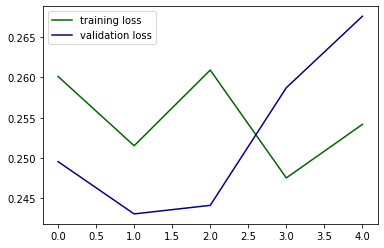

19/19 [==============================] - 4s 203ms/step - loss: 0.2862 - accuracy: 0.8900
Test Accuracy of Conv1D model is 89.0


In [ ]:
###### Random Rotations
x_rotation = x_train_reshape
# define data preparation
datagen_rotation = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen_rotation.fit(x_rotation)
# plot
plot_train_augmentation(x_rotation)

The best accuracy so far is still remain the same, which is 89%.

In [ ]:
# save model
model_aug.save('best_model_CNN.h5') 

# 6. Compare RNNs and CNNs

In [ ]:
# combine training and validation set 
X_valid_and_train_reshape = np.concatenate((x_train_reshape, x_valid_reshape), axis=0)
y_valid_and_train = np.concatenate((y_train_reshape, y_valid_reshape), axis=0)
# check shape
print(X_valid_and_train_reshape.shape)
print(y_valid_and_train.shape)

(3400, 100, 100, 1)
(3400, 4)


In [ ]:
model_aug.compile(loss="categorical_crossentropy", # for one hot encode output 
              # The RMSprop optimizer restricts the oscillations in the vertical direction. 
              # Therefore, we can increase our learning rate and our algorithm could take larger steps 
              # in the horizontal direction converging faster. 
              optimizer='rmsprop',
              metrics=['accuracy'])
model_aug.fit(X_valid_and_train_reshape, y_valid_and_train, epochs=40,
                    validation_data=(x_test_reshape, y_test_reshape),
                    verbose=1, 
                    )

Epoch 1/40
107/107 [==============================] - 136s 1s/step - loss: 1.4632 - accuracy: 0.2547 - val_loss: 1.3869 - val_accuracy: 0.2667
Epoch 2/40
107/107 [==============================] - 134s 1s/step - loss: 1.4068 - accuracy: 0.2621 - val_loss: 1.3632 - val_accuracy: 0.5367
Epoch 3/40
107/107 [==============================] - 136s 1s/step - loss: 0.8370 - accuracy: 0.7174 - val_loss: 0.4159 - val_accuracy: 0.8717
Epoch 4/40
107/107 [==============================] - 142s 1s/step - loss: 0.2867 - accuracy: 0.8868 - val_loss: 0.3009 - val_accuracy: 0.8900
Epoch 5/40
107/107 [==============================] - 133s 1s/step - loss: 0.2587 - accuracy: 0.8900 - val_loss: 0.2612 - val_accuracy: 0.8900
Epoch 6/40
107/107 [==============================] - 133s 1s/step - loss: 0.2474 - accuracy: 0.8891 - val_loss: 0.2860 - val_accuracy: 0.8900
Epoch 7/40
107/107 [==============================] - 133s 1s/step - loss: 0.2391 - accuracy: 0.8938 - val_loss: 0.2463 - val_accuracy: 0.8900

In [ ]:
val_loss_1, val_acc_1 = model_aug.evaluate(x_test_reshape, y_test_reshape)  # evaluate the out of sample data with model
print("Model's loss (error) is",val_loss_1)  # model's loss (error)
print("Model's accuracy is",val_acc_1)  # model's accuracy

19/19 [==============================] - 4s 227ms/step - loss: 0.2635 - accuracy: 0.8667
Model's loss (error) is 0.2635018527507782
Model's accuracy is 0.8666666746139526


The model accuracy has been still high. It has proved that our model has not been overfitted. Also, when we combine train and validation data as train data, the model still keeping the accuracy above 85%, which is quite high when fitting into real-world data. Comparing models (RNN and CNN), we fing the CNN model presents speedy and high accuracy scores as opposed to RNN. Note that the goal is to dectect minor faults in the wind turbine, as many as possible, to prevent from inccuring high cost maintenance. Therefore, accuracy metric is used to decide which model is the most appropriate. The effectiveness in translating time series to detect specific patterns also show here. Shortly, CNN model is the most approprite model considering context and goals of the project.